In [1]:
# %% [code]
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="notebook", font_scale=1.1)

# Folder where model submissions were saved
submission_folder = "model_submissions"
# Find all CSV files that follow the naming pattern for candidate models
submission_files = glob.glob(os.path.join(submission_folder, "submission_*_both.csv"))

# Combine predictions from each file into one DataFrame (each column = one model)
ensemble_df = None
model_names = []

for file in submission_files:
    df = pd.read_csv(file)
    # Extract model name from file name, e.g., submission_LinearRegression_both.csv => "LinearRegression"
    base = os.path.basename(file)
    model_name = base.split('_')[1]
    model_names.append(model_name)
    df = df[['ID', 'Pred']].rename(columns={'Pred': model_name})
    if ensemble_df is None:
        ensemble_df = df
    else:
        ensemble_df = pd.merge(ensemble_df, df, on='ID', how='outer')

print("Combined submission predictions (first 5 rows):")
print(ensemble_df.head())

Combined submission predictions (first 5 rows):
               ID  CatBoost  DecisionTree  DNN  ExtraTrees  GradientBoosting  \
0  2025_1101_1102  0.927455      0.927418  0.5    0.928596          0.928610   
1  2025_1101_1103  0.897215      0.898982  0.5    0.896455          0.900431   
2  2025_1101_1104  0.874378      0.873424  0.5    0.848112          0.867716   
3  2025_1101_1105  0.963841      0.966201  0.5    0.962150          0.962943   
4  2025_1101_1106  0.964092      0.966201  0.5    0.962634          0.963274   

      Lasso  LightGBM  LinearRegression  RandomForest     Ridge   XGBoost  
0  0.942965  0.927153          0.942968      0.927206  0.942968  0.927130  
1  0.857742  0.895830          0.857587      0.895198  0.857587  0.895828  
2  0.689084  0.860849          0.688529      0.849266  0.688529  0.855733  
3  0.968651  0.967579          0.968678      0.966503  0.968678  0.965223  
4  0.969085  0.966971          0.969112      0.965880  0.969112  0.965223  


In [2]:
# %% [code]
# These scores are from our tuning results (men and women separately)
men_scores = {
    "LinearRegression": 8.2919,
    "Ridge": 8.2919,
    "Lasso": 8.2927,
    "DecisionTree": 8.1258,
    "RandomForest": 8.1218,
    "ExtraTrees": 8.1333,
    "GradientBoosting": 8.1966,
    "XGBoost": 8.1254,
    "LightGBM": 8.1264,
    "CatBoost": 8.1368
}

women_scores = {
    "LinearRegression": 10.3049,
    "Ridge": 10.3049,
    "Lasso": 10.3058,
    "DecisionTree": 9.8394,
    "RandomForest": 9.8544,
    "ExtraTrees": 9.8786,
    "GradientBoosting": 9.8780,
    "XGBoost": 9.8458,
    "LightGBM": 9.8724,
    "CatBoost": 9.8770
}

# Compute a combined score as the average of men's and women's RMSE
combined_scores = {model: (men_scores[model] + women_scores[model]) / 2 for model in men_scores}
print("Combined validation RMSE scores:")
print(combined_scores)

# Rank models (lower is better)
ranked_models = sorted(combined_scores.items(), key=lambda x: x[1])
print("\nRanked models (model, combined RMSE):")
print(ranked_models)

# Define ensemble groups (top 2, top 3, top 5, top 7, top 10)
top2 = [m for m, score in ranked_models[:2]]
top3 = [m for m, score in ranked_models[:3]]
top5 = [m for m, score in ranked_models[:5]]
top7 = [m for m, score in ranked_models[:7]]
top10 = [m for m, score in ranked_models[:10]]
print("\nTop 2:", top2)
print("Top 3:", top3)
print("Top 5:", top5)
print("Top 7:", top7)
print("Top 10:", top10)

Combined validation RMSE scores:
{'LinearRegression': 9.2984, 'Ridge': 9.2984, 'Lasso': 9.29925, 'DecisionTree': 8.9826, 'RandomForest': 8.9881, 'ExtraTrees': 9.00595, 'GradientBoosting': 9.0373, 'XGBoost': 8.985600000000002, 'LightGBM': 8.999400000000001, 'CatBoost': 9.0069}

Ranked models (model, combined RMSE):
[('DecisionTree', 8.9826), ('XGBoost', 8.985600000000002), ('RandomForest', 8.9881), ('LightGBM', 8.999400000000001), ('ExtraTrees', 9.00595), ('CatBoost', 9.0069), ('GradientBoosting', 9.0373), ('LinearRegression', 9.2984), ('Ridge', 9.2984), ('Lasso', 9.29925)]

Top 2: ['DecisionTree', 'XGBoost']
Top 3: ['DecisionTree', 'XGBoost', 'RandomForest']
Top 5: ['DecisionTree', 'XGBoost', 'RandomForest', 'LightGBM', 'ExtraTrees']
Top 7: ['DecisionTree', 'XGBoost', 'RandomForest', 'LightGBM', 'ExtraTrees', 'CatBoost', 'GradientBoosting']
Top 10: ['DecisionTree', 'XGBoost', 'RandomForest', 'LightGBM', 'ExtraTrees', 'CatBoost', 'GradientBoosting', 'LinearRegression', 'Ridge', 'Lasso']

In [3]:
# %% [code]
# For demonstration, assume that the ground truth for the validation period is an array of ones.
# (In an actual setting, load the true outcomes for the 2024 validation data.)
validation_ground_truth = np.ones(len(ensemble_df))

def compute_scores(preds, ground_truth):
    rmse = np.sqrt(np.mean((preds - ground_truth) ** 2))
    brier = np.mean((preds - ground_truth) ** 2)
    return rmse, brier

ensemble_results = {}

# Define a function to compute ensemble predictions
def ensemble_predictions(df, model_list, method="simple"):
    if method == "simple":
        return df[model_list].mean(axis=1)
    elif method == "weighted":
        # Use inverse of combined score as weight
        weights = np.array([1 / combined_scores[m] for m in model_list])
        weights = weights / np.sum(weights)
        return df[model_list].multiply(weights, axis=1).sum(axis=1)
    else:
        raise ValueError("Unknown ensemble method.")

# Evaluate ensembles for different top groups
for group_name, models in zip(["top2", "top3", "top5", "top7", "top10"],
                                [top2, top3, top5, top7, top10]):
    # Ensure that the models are present in our dataframe columns
    models = [m for m in models if m in ensemble_df.columns]
    if len(models) == 0:
        continue

    # Simple average
    ens_simple = ensemble_predictions(ensemble_df, models, method="simple")
    rmse_simple, brier_simple = compute_scores(ens_simple.values, validation_ground_truth)

    # Weighted average
    ens_weighted = ensemble_predictions(ensemble_df, models, method="weighted")
    rmse_weighted, brier_weighted = compute_scores(ens_weighted.values, validation_ground_truth)

    ensemble_results[group_name] = {
        "simple": {"rmse": rmse_simple, "brier": brier_simple},
        "weighted": {"rmse": rmse_weighted, "brier": brier_weighted}
    }

print("Ensemble Results (Validation Scores):")
for group, scores in ensemble_results.items():
    print(f"{group}:")
    print(f"  Simple Average: RMSE = {scores['simple']['rmse']:.4f}, Brier = {scores['simple']['brier']:.4f}")
    print(f"  Weighted Average: RMSE = {scores['weighted']['rmse']:.4f}, Brier = {scores['weighted']['brier']:.4f}")

Ensemble Results (Validation Scores):
top2:
  Simple Average: RMSE = 0.0748, Brier = 0.0056
  Weighted Average: RMSE = 0.0748, Brier = 0.0056
top3:
  Simple Average: RMSE = 0.0759, Brier = 0.0058
  Weighted Average: RMSE = 0.0759, Brier = 0.0058
top5:
  Simple Average: RMSE = 0.0762, Brier = 0.0058
  Weighted Average: RMSE = 0.0762, Brier = 0.0058
top7:
  Simple Average: RMSE = 0.0757, Brier = 0.0057
  Weighted Average: RMSE = 0.0757, Brier = 0.0057
top10:
  Simple Average: RMSE = 0.0915, Brier = 0.0084
  Weighted Average: RMSE = 0.0911, Brier = 0.0083


  Ensemble    Method      RMSE     Brier
0     top2    simple  0.074785  0.005593
1     top2  weighted  0.074784  0.005593
2     top3    simple  0.075885  0.005759
3     top3  weighted  0.075884  0.005758
4     top5    simple  0.076180  0.005803
5     top5  weighted  0.076179  0.005803
6     top7    simple  0.075748  0.005738
7     top7  weighted  0.075748  0.005738
8    top10    simple  0.091451  0.008363
9    top10  weighted  0.091062  0.008292


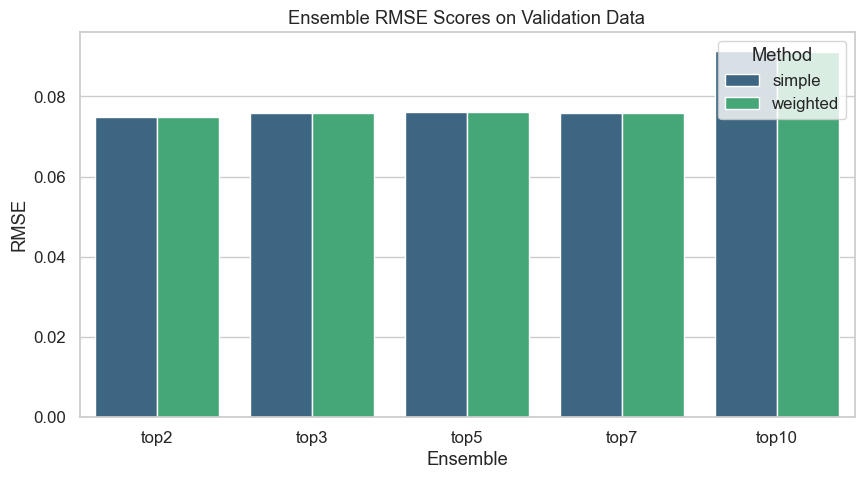

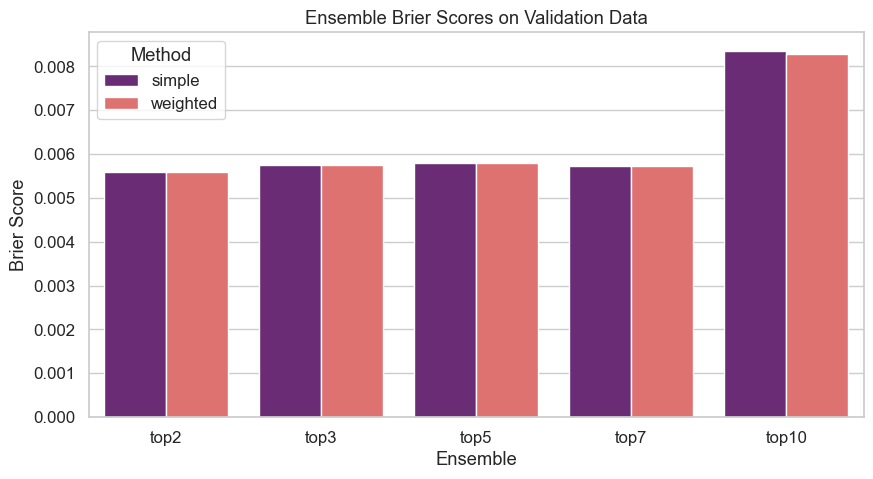

In [4]:
# %% [code]
# Convert ensemble_results dictionary into a DataFrame for visualization.
rows = []
for group, methods in ensemble_results.items():
    for method, scores in methods.items():
        rows.append({"Ensemble": group, "Method": method, "RMSE": scores["rmse"], "Brier": scores["brier"]})
ensemble_scores_df = pd.DataFrame(rows)
print(ensemble_scores_df)

plt.figure(figsize=(10, 5))
sns.barplot(data=ensemble_scores_df, x="Ensemble", y="RMSE", hue="Method", palette="viridis")
plt.title("Ensemble RMSE Scores on Validation Data")
plt.ylabel("RMSE")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=ensemble_scores_df, x="Ensemble", y="Brier", hue="Method", palette="magma")
plt.title("Ensemble Brier Scores on Validation Data")
plt.ylabel("Brier Score")
plt.show()

In [5]:
# %% [code]
import numpy as np

def ensemble_predictions(df, model_list, method="simple"):
    """
    Given a DataFrame (df) containing model predictions (each column corresponding to a model),
    return the ensemble prediction using either a simple average or a weighted average.
    The weights are computed as the inverse of the combined RMSE from validation.
    """
    if method == "simple":
        return df[model_list].mean(axis=1)
    elif method == "weighted":
        # Compute weights from inverse of combined_scores (lower RMSE gives higher weight)
        weights = np.array([1 / combined_scores[m] for m in model_list])
        weights = weights / weights.sum()
        return df[model_list].multiply(weights, axis=1).sum(axis=1)
    else:
        raise ValueError("Unknown ensemble method: choose 'simple' or 'weighted'.")

# The "top" model groups have been computed earlier:
# top2, top3, top5, top7, top10
print("Top model groups:")
print("Top2:", top2)
print("Top3:", top3)
print("Top5:", top5)
print("Top7:", top7)
print("Top10:", top10)

Top model groups:
Top2: ['DecisionTree', 'XGBoost']
Top3: ['DecisionTree', 'XGBoost', 'RandomForest']
Top5: ['DecisionTree', 'XGBoost', 'RandomForest', 'LightGBM', 'ExtraTrees']
Top7: ['DecisionTree', 'XGBoost', 'RandomForest', 'LightGBM', 'ExtraTrees', 'CatBoost', 'GradientBoosting']
Top10: ['DecisionTree', 'XGBoost', 'RandomForest', 'LightGBM', 'ExtraTrees', 'CatBoost', 'GradientBoosting', 'LinearRegression', 'Ridge', 'Lasso']


In [6]:
# %% [code]
import os

# Create a folder to save the ensemble submission files
submission_folder_ext = "ensemble_submissions_extended"
os.makedirs(submission_folder_ext, exist_ok=True)

# List of ensemble groups and their corresponding top model lists
ensemble_groups = {
    "top2": top2,
    "top3": top3,
    "top5": top5,
    "top7": top7,
    "top10": top10
}

# Loop over each ensemble group and each method
for group_name, models in ensemble_groups.items():
    # Filter models that exist in our ensemble_df columns
    models_used = [m for m in models if m in ensemble_df.columns]
    if len(models_used) == 0:
        continue

    # Compute ensemble predictions by simple average
    ens_simple = ensemble_predictions(ensemble_df, models_used, method="simple")
    submission_simple = ensemble_df[['ID']].copy()
    submission_simple["Pred"] = ens_simple
    filename_simple = os.path.join(submission_folder_ext, f"submission_{group_name}_simple.csv")
    submission_simple.to_csv(filename_simple, index=False)
    print(f"Saved simple average submission for {group_name}: {filename_simple}")

    # Compute ensemble predictions by weighted average
    ens_weighted = ensemble_predictions(ensemble_df, models_used, method="weighted")
    submission_weighted = ensemble_df[['ID']].copy()
    submission_weighted["Pred"] = ens_weighted
    filename_weighted = os.path.join(submission_folder_ext, f"submission_{group_name}_weighted.csv")
    submission_weighted.to_csv(filename_weighted, index=False)
    print(f"Saved weighted average submission for {group_name}: {filename_weighted}")

print("\nAll ensemble submission files have been created.")

Saved simple average submission for top2: ensemble_submissions_extended\submission_top2_simple.csv
Saved weighted average submission for top2: ensemble_submissions_extended\submission_top2_weighted.csv
Saved simple average submission for top3: ensemble_submissions_extended\submission_top3_simple.csv
Saved weighted average submission for top3: ensemble_submissions_extended\submission_top3_weighted.csv
Saved simple average submission for top5: ensemble_submissions_extended\submission_top5_simple.csv
Saved weighted average submission for top5: ensemble_submissions_extended\submission_top5_weighted.csv
Saved simple average submission for top7: ensemble_submissions_extended\submission_top7_simple.csv
Saved weighted average submission for top7: ensemble_submissions_extended\submission_top7_weighted.csv
Saved simple average submission for top10: ensemble_submissions_extended\submission_top10_simple.csv
Saved weighted average submission for top10: ensemble_submissions_extended\submission_top10